In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score
import copy

from src.train import trainModel
#from src.dataloader import getData,spliceDataset,h5pyDataset,collate_fn
from src.dataloader import getData,spliceDataset,h5pyDataset,getDataPointList,getDataPointListFull,DataPointFull
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d
from src.model import SpliceFormer
from src.evaluation_metrics import print_topl_statistics,cross_entropy_2d

In [2]:
!nvidia-smi

Wed Nov 22 10:40:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:31:00.0 Off |                    0 |
| N/A   36C    P0    37W / 250W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:98:00.0 Off |                    0 |
| N/A   

In [3]:
#!pip install pickle5

In [4]:
rng = np.random.default_rng(23673)

In [5]:
#gtf = None

In [6]:
L = 32
N_GPUS = 3
k = 2
NUM_ACCUMULATION_STEPS=1
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = 16*k*N_GPUS

k = NUM_ACCUMULATION_STEPS*k

CL = 2 * np.sum(AR*(W-1))

In [7]:
data_dir = '../Data'
setType = 'train'
annotation, transcriptToLabel, seqData = getData(data_dir, setType)

In [8]:
# Maximum nucleotide context length (CL_max/2 on either side of the 
# position of interest)
# CL_max should be an even number
# Sequence length of SpliceAIs (SL+CL will be the input length and
# SL will be the output length)

SL=5000
CL_max=40000

In [9]:
assert CL_max % 2 == 0

In [10]:
train_gene, validation_gene = train_test_split(annotation['gene'].drop_duplicates(),test_size=.1,random_state=435)
annotation_train = annotation[annotation['gene'].isin(train_gene)]
annotation_validation = annotation[annotation['gene'].isin(validation_gene)]

In [11]:
train_dataset = spliceDataset(getDataPointListFull(annotation_train,transcriptToLabel,SL,CL_max,shift=SL))
val_dataset = spliceDataset(getDataPointListFull(annotation_validation,transcriptToLabel,SL,CL_max,shift=SL))
train_dataset.seqData = seqData
val_dataset.seqData = seqData

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
hs = []
learning_rate= k*1e-3
gamma=0.5
#final_lr = 1e-5
#gamma = 1/(learning_rate/final_lr)**(1/5) 

Epoch (train) 1/10: 100%|████████████| 2716/2716 [55:55<00:00,  1.24s/it, a_r=0.874, d_r=0.89, loss=0.000217, r_a=0.998, r_d=0.999, r_loss=6.49]


epoch: 1/10, train loss = 0.015237


Epoch (train) 2/10: 100%|███████████| 2716/2716 [56:16<00:00,  1.24s/it, a_r=0.894, d_r=0.906, loss=0.000189, r_a=0.998, r_d=0.999, r_loss=5.56]


epoch: 2/10, train loss = 0.000190


Epoch (train) 3/10: 100%|███████████| 2716/2716 [56:31<00:00,  1.25s/it, a_r=0.912, d_r=0.917, loss=0.000173, r_a=0.999, r_d=0.998, r_loss=4.48]


epoch: 3/10, train loss = 0.000171


Epoch (train) 4/10: 100%|███████████| 2716/2716 [56:13<00:00,  1.24s/it, a_r=0.923, d_r=0.929, loss=0.000148, r_a=0.999, r_d=0.999, r_loss=3.65]


epoch: 4/10, train loss = 0.000159


Epoch (train) 5/10: 100%|███████████| 2716/2716 [56:21<00:00,  1.25s/it, a_r=0.931, d_r=0.933, loss=0.000145, r_a=0.999, r_d=0.999, r_loss=2.88]


epoch: 5/10, train loss = 0.000146


Epoch (train) 6/10: 100%|███████████| 2716/2716 [56:20<00:00,  1.24s/it, a_r=0.936, d_r=0.944, loss=0.000126, r_a=0.999, r_d=0.999, r_loss=2.32]


epoch: 6/10, train loss = 0.000133


Epoch (train) 7/10: 100%|███████████| 2716/2716 [56:07<00:00,  1.24s/it, a_r=0.955, d_r=0.961, loss=0.000101, r_a=0.999, r_d=0.999, r_loss=2.69]


epoch: 7/10, train loss = 0.000108


Epoch (train) 8/10: 100%|█████████████| 2716/2716 [56:21<00:00,  1.25s/it, a_r=0.962, d_r=0.964, loss=9.22e-5, r_a=0.999, r_d=0.999, r_loss=2.4]


epoch: 8/10, train loss = 0.000091


Epoch (train) 9/10: 100%|████████████| 2716/2716 [56:19<00:00,  1.24s/it, a_r=0.964, d_r=0.969, loss=7.98e-5, r_a=0.999, r_d=0.999, r_loss=2.44]


epoch: 9/10, train loss = 0.000078


Epoch (train) 10/10: 100%|███████████████| 2716/2716 [56:10<00:00,  1.24s/it, a_r=0.971, d_r=0.973, loss=6.61e-5, r_a=0.999, r_d=1, r_loss=2.45]


epoch: 10/10, train loss = 0.000070


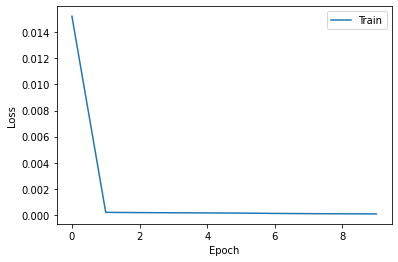

Epoch (train) 1/10: 100%|████████████| 2716/2716 [56:06<00:00,  1.24s/it, a_r=0.87, d_r=0.885, loss=0.000222, r_a=0.997, r_d=0.998, r_loss=5.46]


epoch: 1/10, train loss = 0.015872


Epoch (train) 2/10: 100%|████████████| 2716/2716 [56:25<00:00,  1.25s/it, a_r=0.901, d_r=0.91, loss=0.000185, r_a=0.998, r_d=0.998, r_loss=3.86]


epoch: 2/10, train loss = 0.000193


Epoch (train) 3/10: 100%|███████████| 2716/2716 [56:18<00:00,  1.24s/it, a_r=0.906, d_r=0.915, loss=0.000172, r_a=0.998, r_d=0.999, r_loss=2.93]


epoch: 3/10, train loss = 0.000173


Epoch (train) 4/10: 100%|████████████| 2716/2716 [56:31<00:00,  1.25s/it, a_r=0.92, d_r=0.926, loss=0.000156, r_a=0.998, r_d=0.999, r_loss=2.22]


epoch: 4/10, train loss = 0.000159


Epoch (train) 5/10: 100%|███████████| 2716/2716 [56:39<00:00,  1.25s/it, a_r=0.924, d_r=0.932, loss=0.000145, r_a=0.998, r_d=0.999, r_loss=1.77]


epoch: 5/10, train loss = 0.000147


Epoch (train) 6/10: 100%|███████████| 2716/2716 [56:21<00:00,  1.25s/it, a_r=0.935, d_r=0.941, loss=0.000139, r_a=0.999, r_d=0.999, r_loss=1.57]


epoch: 6/10, train loss = 0.000135


Epoch (train) 7/10: 100%|████████████| 2716/2716 [56:21<00:00,  1.24s/it, a_r=0.95, d_r=0.955, loss=0.000108, r_a=0.999, r_d=0.999, r_loss=1.56]


epoch: 7/10, train loss = 0.000109


Epoch (train) 8/10: 100%|█████████████| 2716/2716 [56:36<00:00,  1.25s/it, a_r=0.962, d_r=0.964, loss=9.19e-5, r_a=0.999, r_d=0.999, r_loss=1.8]


epoch: 8/10, train loss = 0.000091


Epoch (train) 9/10: 100%|█████████████| 2716/2716 [56:41<00:00,  1.25s/it, a_r=0.965, d_r=0.97, loss=8.16e-5, r_a=0.999, r_d=0.999, r_loss=1.81]


epoch: 9/10, train loss = 0.000080


Epoch (train) 10/10: 100%|████████████| 2716/2716 [56:19<00:00,  1.24s/it, a_r=0.968, d_r=0.973, loss=7.1e-5, r_a=0.999, r_d=0.999, r_loss=1.92]

epoch: 10/10, train loss = 0.000071


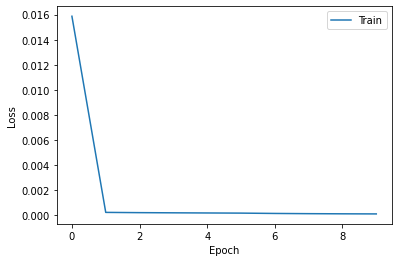

Epoch (train) 1/10: 100%|████████████| 2716/2716 [56:14<00:00,  1.24s/it, a_r=0.871, d_r=0.884, loss=0.000222, r_a=0.996, r_d=0.997, r_loss=6.1]


epoch: 1/10, train loss = 0.014111


Epoch (train) 2/10: 100%|███████████| 2716/2716 [56:14<00:00,  1.24s/it, a_r=0.899, d_r=0.911, loss=0.000178, r_a=0.998, r_d=0.998, r_loss=4.06]


epoch: 2/10, train loss = 0.000192


Epoch (train) 3/10: 100%|███████████| 2716/2716 [56:49<00:00,  1.26s/it, a_r=0.911, d_r=0.921, loss=0.000166, r_a=0.998, r_d=0.998, r_loss=3.06]


epoch: 3/10, train loss = 0.000171


Epoch (train) 4/10: 100%|███████████| 2716/2716 [56:57<00:00,  1.26s/it, a_r=0.918, d_r=0.929, loss=0.000163, r_a=0.999, r_d=0.999, r_loss=2.39]


epoch: 4/10, train loss = 0.000159


Epoch (train) 5/10: 100%|███████████| 2716/2716 [57:01<00:00,  1.26s/it, a_r=0.929, d_r=0.937, loss=0.000141, r_a=0.999, r_d=0.999, r_loss=1.75]


epoch: 5/10, train loss = 0.000145


Epoch (train) 6/10: 100%|███████████| 2716/2716 [56:07<00:00,  1.24s/it, a_r=0.932, d_r=0.939, loss=0.000136, r_a=0.999, r_d=0.999, r_loss=1.83]


epoch: 6/10, train loss = 0.000135


Epoch (train) 7/10: 100%|████████████| 2716/2716 [56:33<00:00,  1.25s/it, a_r=0.951, d_r=0.958, loss=0.000107, r_a=0.999, r_d=0.999, r_loss=1.7]


epoch: 7/10, train loss = 0.000108


Epoch (train) 8/10: 100%|████████████| 2716/2716 [56:40<00:00,  1.25s/it, a_r=0.961, d_r=0.964, loss=9.34e-5, r_a=0.999, r_d=0.999, r_loss=1.66]


epoch: 8/10, train loss = 0.000091


Epoch (train) 9/10: 100%|███████████████| 2716/2716 [56:54<00:00,  1.26s/it, a_r=0.963, d_r=0.968, loss=8.06e-5, r_a=0.999, r_d=0.999, r_loss=2]


epoch: 9/10, train loss = 0.000079


Epoch (train) 10/10: 100%|████████████| 2716/2716 [56:38<00:00,  1.25s/it, a_r=0.971, d_r=0.97, loss=6.94e-5, r_a=0.999, r_d=0.999, r_loss=1.93]

epoch: 10/10, train loss = 0.000071


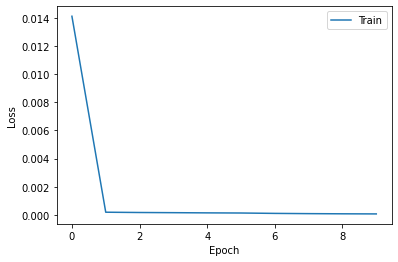

In [13]:
for model_nr in range(3):
    model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2)
    model_m.apply(keras_init)
    model_m = model_m.to(device)
    if torch.cuda.device_count() > 1:
        #print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model_m = nn.DataParallel(model_m)
    
    modelFileName = '../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(model_nr)
    loss = categorical_crossentropy_2d().loss
    optimizer = torch.optim.AdamW(model_m.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    warmup = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)
    h = trainModel(model_m,modelFileName,loss,train_loader,val_loader,optimizer,scheduler,warmup,BATCH_SIZE,epochs,device,skipValidation=True,NUM_ACCUMULATION_STEPS=NUM_ACCUMULATION_STEPS)
    hs.append(h)

    plt.plot(range(epochs),h['loss'],label='Train')
    #plt.plot(range(epochs),h['val_loss'],label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch (train) 1/10: 100%|████████████| 2716/2716 [55:15<00:00,  1.22s/it, a_r=0.87, d_r=0.884, loss=0.000218, r_a=0.997, r_d=0.989, r_loss=5.81]


epoch: 1/10, train loss = 0.015869


Epoch (train) 2/10: 100%|█████████████| 2716/2716 [55:19<00:00,  1.22s/it, a_r=0.9, d_r=0.912, loss=0.000183, r_a=0.999, r_d=0.992, r_loss=4.01]


epoch: 2/10, train loss = 0.000191


Epoch (train) 3/10: 100%|█| 2716/2716 [55:58<00:00,  1.24s/it, a_r=0.914, d_r=0.921, loss=0.000164, r_a=0.999, 


epoch: 3/10, train loss = 0.000171


Epoch (train) 4/10: 100%|█| 2716/2716 [55:31<00:00,  1.23s/it, a_r=0.918, d_r=0.93, loss=0.000154, r_a=0.999, r


epoch: 4/10, train loss = 0.000158


Epoch (train) 5/10: 100%|█| 2716/2716 [55:49<00:00,  1.23s/it, a_r=0.924, d_r=0.929, loss=0.000152, r_a=0.999, 


epoch: 5/10, train loss = 0.000147


Epoch (train) 6/10: 100%|█| 2716/2716 [55:47<00:00,  1.23s/it, a_r=0.936, d_r=0.943, loss=0.000137, r_a=0.999, 


epoch: 6/10, train loss = 0.000136


Epoch (train) 7/10: 100%|█| 2716/2716 [55:48<00:00,  1.23s/it, a_r=0.952, d_r=0.956, loss=0.000114, r_a=0.999, 


epoch: 7/10, train loss = 0.000110


Epoch (train) 8/10: 100%|█| 2716/2716 [56:03<00:00,  1.24s/it, a_r=0.96, d_r=0.963, loss=9.62e-5, r_a=0.999, r_


epoch: 8/10, train loss = 0.000093


Epoch (train) 9/10: 100%|█| 2716/2716 [56:00<00:00,  1.24s/it, a_r=0.968, d_r=0.969, loss=7.83e-5, r_a=0.999, r


epoch: 9/10, train loss = 0.000080


Epoch (train) 10/10: 100%|█| 2716/2716 [55:50<00:00,  1.23s/it, a_r=0.967, d_r=0.972, loss=6.89e-5, r_a=0.999, 


epoch: 10/10, train loss = 0.000072


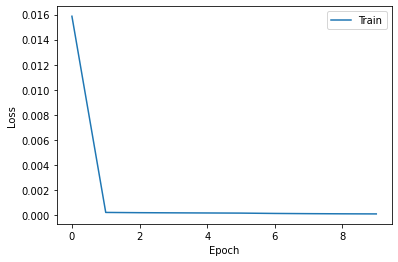

Epoch (train) 1/10: 100%|█| 2716/2716 [55:34<00:00,  1.23s/it, a_r=0.876, d_r=0.889, loss=0.000209, r_a=0.996, 


epoch: 1/10, train loss = 0.015180


Epoch (train) 2/10: 100%|█| 2716/2716 [55:34<00:00,  1.23s/it, a_r=0.902, d_r=0.91, loss=0.000181, r_a=0.998, r


epoch: 2/10, train loss = 0.000191


Epoch (train) 3/10: 100%|█| 2716/2716 [55:54<00:00,  1.24s/it, a_r=0.912, d_r=0.921, loss=0.000169, r_a=0.998, 


epoch: 3/10, train loss = 0.000173


Epoch (train) 4/10: 100%|█| 2716/2716 [56:03<00:00,  1.24s/it, a_r=0.919, d_r=0.926, loss=0.000158, r_a=0.998, 


epoch: 4/10, train loss = 0.000161


Epoch (train) 5/10: 100%|█| 2716/2716 [56:08<00:00,  1.24s/it, a_r=0.932, d_r=0.939, loss=0.000143, r_a=0.999, 


epoch: 5/10, train loss = 0.000149


Epoch (train) 6/10: 100%|█| 2716/2716 [56:10<00:00,  1.24s/it, a_r=0.933, d_r=0.938, loss=0.000136, r_a=0.999, 


epoch: 6/10, train loss = 0.000137


Epoch (train) 7/10: 100%|█| 2716/2716 [55:27<00:00,  1.23s/it, a_r=0.954, d_r=0.956, loss=0.000106, r_a=0.999, 


epoch: 7/10, train loss = 0.000110


Epoch (train) 8/10: 100%|█| 2716/2716 [55:55<00:00,  1.24s/it, a_r=0.962, d_r=0.966, loss=9.17e-5, r_a=0.999, r


epoch: 8/10, train loss = 0.000093


Epoch (train) 9/10: 100%|█| 2716/2716 [55:47<00:00,  1.23s/it, a_r=0.966, d_r=0.967, loss=8.22e-5, r_a=0.999, r


epoch: 9/10, train loss = 0.000080


Epoch (train) 10/10: 100%|████████████| 2716/2716 [56:02<00:00,  1.24s/it, a_r=0.969, d_r=0.97, loss=7.14e-5, r_a=0.999, r_d=0.999, r_loss=3.66]

epoch: 10/10, train loss = 0.000072


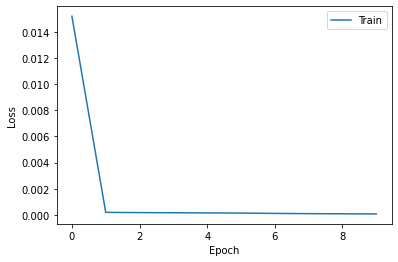

Epoch (train) 1/10: 100%|████████████| 2716/2716 [55:43<00:00,  1.23s/it, a_r=0.88, d_r=0.891, loss=0.000213, r_a=0.996, r_d=0.998, r_loss=6.11]


epoch: 1/10, train loss = 0.015477


Epoch (train) 2/10: 100%|███████████| 2716/2716 [55:39<00:00,  1.23s/it, a_r=0.899, d_r=0.909, loss=0.000181, r_a=0.998, r_d=0.998, r_loss=4.85]


epoch: 2/10, train loss = 0.000191


Epoch (train) 3/10: 100%|████████████| 2716/2716 [56:01<00:00,  1.24s/it, a_r=0.91, d_r=0.919, loss=0.000166, r_a=0.998, r_d=0.999, r_loss=4.96]


epoch: 3/10, train loss = 0.000172


Epoch (train) 4/10: 100%|████████████| 2716/2716 [55:20<00:00,  1.22s/it, a_r=0.921, d_r=0.93, loss=0.000158, r_a=0.999, r_d=0.999, r_loss=5.07]


epoch: 4/10, train loss = 0.000161


Epoch (train) 5/10: 100%|████████████| 2716/2716 [55:41<00:00,  1.23s/it, a_r=0.93, d_r=0.937, loss=0.000142, r_a=0.999, r_d=0.999, r_loss=3.97]


epoch: 5/10, train loss = 0.000148


Epoch (train) 6/10: 100%|███████████| 2716/2716 [55:39<00:00,  1.23s/it, a_r=0.938, d_r=0.941, loss=0.000133, r_a=0.999, r_d=0.999, r_loss=4.28]


epoch: 6/10, train loss = 0.000137


Epoch (train) 7/10: 100%|███████████| 2716/2716 [55:30<00:00,  1.23s/it, a_r=0.952, d_r=0.955, loss=0.000113, r_a=0.998, r_d=0.999, r_loss=3.91]


epoch: 7/10, train loss = 0.000110


Epoch (train) 8/10: 100%|█████████████| 2716/2716 [55:36<00:00,  1.23s/it, a_r=0.96, d_r=0.962, loss=9.47e-5, r_a=0.999, r_d=0.999, r_loss=3.43]


epoch: 8/10, train loss = 0.000092


Epoch (train) 9/10: 100%|████████████| 2716/2716 [55:31<00:00,  1.23s/it, a_r=0.964, d_r=0.965, loss=7.88e-5, r_a=0.999, r_d=0.999, r_loss=3.31]


epoch: 9/10, train loss = 0.000080


Epoch (train) 10/10: 100%|████████████████| 2716/2716 [55:14<00:00,  1.22s/it, a_r=0.967, d_r=0.97, loss=7.26e-5, r_a=1, r_d=0.999, r_loss=3.37]

epoch: 10/10, train loss = 0.000072


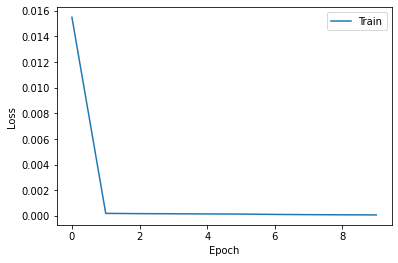

Epoch (train) 1/10: 100%|████████████| 2716/2716 [55:55<00:00,  1.24s/it, a_r=0.878, d_r=0.891, loss=0.000214, r_a=0.997, r_d=0.992, r_loss=6.6]


epoch: 1/10, train loss = 0.014978


Epoch (train) 2/10: 100%|███████████| 2716/2716 [55:41<00:00,  1.23s/it, a_r=0.902, d_r=0.908, loss=0.000183, r_a=0.998, r_d=0.994, r_loss=5.49]


epoch: 2/10, train loss = 0.000191


Epoch (train) 3/10: 100%|███████████| 2716/2716 [55:50<00:00,  1.23s/it, a_r=0.913, d_r=0.922, loss=0.000168, r_a=0.998, r_d=0.993, r_loss=4.12]


epoch: 3/10, train loss = 0.000172


Epoch (train) 4/10: 100%|████████████| 2716/2716 [55:44<00:00,  1.23s/it, a_r=0.925, d_r=0.929, loss=0.00016, r_a=0.999, r_d=0.996, r_loss=3.52]


epoch: 4/10, train loss = 0.000159


Epoch (train) 5/10: 100%|█████████████| 2716/2716 [55:56<00:00,  1.24s/it, a_r=0.93, d_r=0.933, loss=0.000142, r_a=0.999, r_d=0.997, r_loss=4.1]


epoch: 5/10, train loss = 0.000149


Epoch (train) 6/10: 100%|███████████| 2716/2716 [55:25<00:00,  1.22s/it, a_r=0.937, d_r=0.944, loss=0.000131, r_a=0.999, r_d=0.996, r_loss=3.75]


epoch: 6/10, train loss = 0.000137


Epoch (train) 7/10: 100%|███████████| 2716/2716 [55:38<00:00,  1.23s/it, a_r=0.951, d_r=0.955, loss=0.000111, r_a=0.999, r_d=0.995, r_loss=4.22]


epoch: 7/10, train loss = 0.000111


Epoch (train) 8/10: 100%|████████████| 2716/2716 [55:39<00:00,  1.23s/it, a_r=0.964, d_r=0.965, loss=8.73e-5, r_a=0.999, r_d=0.995, r_loss=3.27]


epoch: 8/10, train loss = 0.000093


Epoch (train) 9/10: 100%|████████████| 2716/2716 [55:49<00:00,  1.23s/it, a_r=0.967, d_r=0.971, loss=7.94e-5, r_a=0.999, r_d=0.995, r_loss=3.61]


epoch: 9/10, train loss = 0.000080


Epoch (train) 10/10: 100%|████████████| 2716/2716 [55:30<00:00,  1.23s/it, a_r=0.969, d_r=0.969, loss=7.04e-5, r_a=0.999, r_d=0.997, r_loss=2.9]

epoch: 10/10, train loss = 0.000072


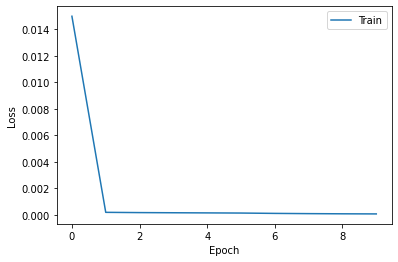

Epoch (train) 1/10: 100%|██████████| 2716/2716 [55:11<00:00,  1.22s/it, a_r=0.86, d_r=0.891, loss=0.000221, r_a=0.00734, r_d=0.997, r_loss=1.75]


epoch: 1/10, train loss = 0.015926


Epoch (train) 2/10: 100%|███████████| 2716/2716 [55:26<00:00,  1.22s/it, a_r=0.896, d_r=0.908, loss=0.000186, r_a=0.997, r_d=0.998, r_loss=5.32]


epoch: 2/10, train loss = 0.000198


Epoch (train) 3/10: 100%|███████████| 2716/2716 [55:09<00:00,  1.22s/it, a_r=0.913, d_r=0.923, loss=0.000169, r_a=0.998, r_d=0.999, r_loss=4.48]


epoch: 3/10, train loss = 0.000173


Epoch (train) 4/10: 100%|████████████| 2716/2716 [55:39<00:00,  1.23s/it, a_r=0.919, d_r=0.927, loss=0.00016, r_a=0.998, r_d=0.999, r_loss=5.04]


epoch: 4/10, train loss = 0.000162


Epoch (train) 5/10: 100%|███████████| 2716/2716 [55:15<00:00,  1.22s/it, a_r=0.927, d_r=0.937, loss=0.000146, r_a=0.999, r_d=0.999, r_loss=4.13]


epoch: 5/10, train loss = 0.000149


Epoch (train) 6/10: 100%|███████████| 2716/2716 [55:40<00:00,  1.23s/it, a_r=0.937, d_r=0.943, loss=0.000139, r_a=0.999, r_d=0.999, r_loss=4.44]


epoch: 6/10, train loss = 0.000138


Epoch (train) 7/10: 100%|███████████| 2716/2716 [55:31<00:00,  1.23s/it, a_r=0.951, d_r=0.956, loss=0.000113, r_a=0.999, r_d=0.999, r_loss=3.62]


epoch: 7/10, train loss = 0.000112


Epoch (train) 8/10: 100%|████████████| 2716/2716 [55:31<00:00,  1.23s/it, a_r=0.961, d_r=0.964, loss=9.04e-5, r_a=0.999, r_d=0.999, r_loss=2.99]


epoch: 8/10, train loss = 0.000093


Epoch (train) 9/10: 100%|████████████| 2716/2716 [55:44<00:00,  1.23s/it, a_r=0.963, d_r=0.966, loss=8.83e-5, r_a=0.999, r_d=0.999, r_loss=1.96]


epoch: 9/10, train loss = 0.000081


Epoch (train) 10/10: 100%|█████████████| 2716/2716 [55:15<00:00,  1.22s/it, a_r=0.967, d_r=0.97, loss=7.7e-5, r_a=0.999, r_d=0.999, r_loss=1.96]

epoch: 10/10, train loss = 0.000072


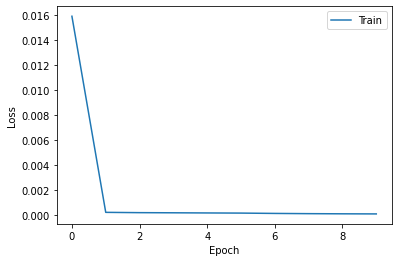

In [13]:
for model_nr in range(5,10):
    model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2)
    model_m.apply(keras_init)
    model_m = model_m.to(device)
    if torch.cuda.device_count() > 1:
        #print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model_m = nn.DataParallel(model_m)
    
    modelFileName = '../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(model_nr)
    loss = categorical_crossentropy_2d().loss
    optimizer = torch.optim.AdamW(model_m.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    warmup = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)
    h = trainModel(model_m,modelFileName,loss,train_loader,val_loader,optimizer,scheduler,warmup,BATCH_SIZE,epochs,device,skipValidation=True,NUM_ACCUMULATION_STEPS=NUM_ACCUMULATION_STEPS)
    hs.append(h)

    plt.plot(range(epochs),h['loss'],label='Train')
    #plt.plot(range(epochs),h['val_loss'],label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h5f = h5py.File('/odinn/tmp/benediktj/Data/SplicePrediction/gencode_40k_dataset_test_.h5')

num_idx = len(h5f.keys())//2

test_dataset = h5pyDataset(h5f,list(range(num_idx)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

temp = 1
n_models = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()
    
Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

for (batch_chunks,target_chunks) in tqdm(test_loader):
    batch_chunks = torch.transpose(batch_chunks[0].to(device),1,2)
    target_chunks = torch.transpose(torch.squeeze(target_chunks[0].to(device),0),1,2)
    #print(np.max(target_chunks.cpu().numpy()[:,2,:]))
    n_chunks = int(np.ceil(batch_chunks.shape[0]/BATCH_SIZE))
    batch_chunks = torch.chunk(batch_chunks, n_chunks, dim=0)
    target_chunks = torch.chunk(target_chunks, n_chunks, dim=0)
    targets_list = []
    outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        targets = target_chunks[j]
        outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
        #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
        outputs = torch.mean(torch.stack(outputs),dim=0)
        #outputs = odds_gmean(torch.stack(outputs))
        #outputs = (outputs[0]+outputs[1]+outputs[2])/n_models
        targets_list.extend(targets.unsqueeze(0))
        outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(torch.vstack(targets_list),1,2).cpu().numpy()
    outputs = torch.transpose(torch.vstack(outputs_list),1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [02:39<00:00,  9.40s/it]


In [16]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.0002340018349389342

Acceptor:
0.9952	0.9491	0.9879	0.9912	0.9769	0.9794	0.3031	0.0018	0.0003	13561	14289.0	14289

Donor:
0.9958	0.9519	0.9896	0.9925	0.9799	0.9790	0.3300	0.0016	0.0002	13601	14289.0	14289


Cross entropy = 0.00037596160351343195

Acceptor:

0.9955	0.95	0.9875	0.9909	0.9773	1.0000	0.0410	0.0000	0.0000	13575	14289.0	14289

Donor:

0.9961	0.9532	0.9899	0.9923	0.9803	1.0000	0.0558	0.0000	0.0000	13620	14289.0	14289


In [17]:
setType = 'test'
annotation_test, transcriptToLabel_test, seqData = getData(data_dir, setType)    

In [18]:
temp = 1
n_models = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListFull(annotation_test,transcriptToLabel_test,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)
    #outputs = odds_gmean(outputs)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1386/1386 [49:00<00:00,  2.12s/it]


In [19]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.0001087605119402784

Acceptor:
0.9808	0.9401	0.9916	0.9956	0.9661	0.9824	0.4289	0.0016	0.0002	84336	89712.0	89712

Donor:
0.9817	0.9452	0.9943	0.9969	0.9698	0.9819	0.4858	0.0015	0.0002	84796	89712.0	89712


In [20]:
df = pd.DataFrame({'Y_true_acceptor':Y_true_acceptor,'Y_pred_acceptor':Y_pred_acceptor,'Y_true_donor':Y_true_donor,'Y_pred_donor':Y_pred_donor})
df.to_csv('/odinn/tmp/benediktj/Data/SplicePrediction-050422/transformer_40k_test_set_predictions_171022_2.gz',index=False)

In [30]:
def odds_gmean(prediction,n_models,a = 1.5):
    p = torch.pow(torch.prod(prediction,dim=0), a/n_models)
    p_neg = torch.pow(torch.prod(1-prediction,dim=0), a/n_models)
    return p / (p+p_neg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h5f = h5py.File('/odinn/tmp/benediktj/Data/SplicePrediction/gencode_40k_dataset_test_.h5')

num_idx = len(h5f.keys())//2

test_dataset = h5pyDataset(h5f,list(range(num_idx)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models[:5])]
#nr = [0,2,3]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_161022_{}'.format(i))) for i,model in enumerate(models[5:])]

for model in models:
    model.eval()
    
Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

for (batch_chunks,target_chunks) in tqdm(test_loader):
    batch_chunks = torch.transpose(batch_chunks[0].to(device),1,2)
    target_chunks = torch.transpose(torch.squeeze(target_chunks[0].to(device),0),1,2)
    #print(np.max(target_chunks.cpu().numpy()[:,2,:]))
    n_chunks = int(np.ceil(batch_chunks.shape[0]/BATCH_SIZE))
    batch_chunks = torch.chunk(batch_chunks, n_chunks, dim=0)
    target_chunks = torch.chunk(target_chunks, n_chunks, dim=0)
    targets_list = []
    outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        targets = target_chunks[j]
        outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
        #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
        outputs = torch.mean(torch.stack(outputs),dim=0)
        #outputs = odds_gmean(torch.stack(outputs),n_models)
        #outputs = (outputs[0]+outputs[1]+outputs[2])/n_models
        targets_list.extend(targets.unsqueeze(0))
        outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(torch.vstack(targets_list),1,2).cpu().numpy()
    outputs = torch.transpose(torch.vstack(outputs_list),1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [04:54<00:00, 17.32s/it]


In [31]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00022591106861107486

Acceptor:
0.9961	0.95	0.9876	0.9914	0.9782	0.9778	0.3168	0.0024	0.0004	13574	14289.0	14289

Donor:
0.9961	0.9533	0.9899	0.9926	0.9807	0.9781	0.3336	0.0020	0.0003	13621	14289.0	14289


In [35]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models[:5])]
#nr = [0,2,3]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_161022_{}'.format(i))) for i,model in enumerate(models[5:])]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListFull(annotation_test,transcriptToLabel_test,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)
    #outputs = odds_gmean(outputs)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1386/1386 [1:27:43<00:00,  3.80s/it]


In [36]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00010540342260087413

Acceptor:
0.9813	0.941	0.9921	0.9959	0.9673	0.9811	0.4463	0.0022	0.0003	84422	89712.0	89712

Donor:
0.9825	0.946	0.9944	0.9971	0.9711	0.9814	0.4852	0.0018	0.0002	84871	89712.0	89712


In [37]:
df = pd.DataFrame({'Y_true_acceptor':Y_true_acceptor,'Y_pred_acceptor':Y_pred_acceptor,'Y_true_donor':Y_true_donor,'Y_pred_donor':Y_pred_donor})
df.to_csv('/odinn/tmp/benediktj/Data/SplicePrediction-050422/transformer_40k_test_set_predictions_191022.gz',index=False)

In [28]:
def odds_gmean(prediction,n_models,a = 1.5):
    p = torch.pow(torch.prod(prediction,dim=0), a/n_models)
    p_neg = torch.pow(torch.prod(1-prediction,dim=0), a/n_models)
    return p / (p+p_neg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h5f = h5py.File('/odinn/tmp/benediktj/Data/SplicePrediction/gencode_40k_dataset_test_.h5')

num_idx = len(h5f.keys())//2

test_dataset = h5pyDataset(h5f,list(range(num_idx)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models[:5])]
#nr = [0,2,3]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_161022_{}'.format(i))) for i,model in enumerate(models[5:])]

for model in models:
    model.eval()
    
Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

for (batch_chunks,target_chunks) in tqdm(test_loader):
    batch_chunks = torch.transpose(batch_chunks[0].to(device),1,2)
    target_chunks = torch.transpose(torch.squeeze(target_chunks[0].to(device),0),1,2)
    #print(np.max(target_chunks.cpu().numpy()[:,2,:]))
    n_chunks = int(np.ceil(batch_chunks.shape[0]/BATCH_SIZE))
    batch_chunks = torch.chunk(batch_chunks, n_chunks, dim=0)
    target_chunks = torch.chunk(target_chunks, n_chunks, dim=0)
    targets_list = []
    outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        targets = target_chunks[j]
        outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
        #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
        #outputs = torch.mean(torch.stack(outputs),dim=0)
        outputs = odds_gmean(torch.stack(outputs),n_models)
        #outputs = (outputs[0]+outputs[1]+outputs[2])/n_models
        targets_list.extend(targets.unsqueeze(0))
        outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(torch.vstack(targets_list),1,2).cpu().numpy()
    outputs = torch.transpose(torch.vstack(outputs_list),1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [04:55<00:00, 17.35s/it]


In [29]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00028597514309361134

Acceptor:
0.9955	0.95	0.9875	0.9909	0.9773	0.9980	0.1311	0.0000	0.0000	13575	14289.0	14289

Donor:
0.9961	0.9532	0.9899	0.9923	0.9803	0.9980	0.1549	0.0000	0.0000	13620	14289.0	14289


In [32]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models[:5])]
#nr = [0,2,3]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_161022_{}'.format(i))) for i,model in enumerate(models[5:])]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListFull(annotation_test,transcriptToLabel_test,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    outputs = torch.stack(outputs)
    #outputs = torch.mean(outputs,dim=0)
    outputs = odds_gmean(outputs,n_models)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1386/1386 [1:23:22<00:00,  3.61s/it]


In [33]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00014547907163697655

Acceptor:
0.9813	0.941	0.9918	0.9955	0.9671	0.9984	0.3592	0.0000	0.0000	84418	89712.0	89712

Donor:
0.9823	0.9459	0.9941	0.9969	0.9707	0.9984	0.4408	0.0000	0.0000	84857	89712.0	89712


In [34]:
df = pd.DataFrame({'Y_true_acceptor':Y_true_acceptor,'Y_pred_acceptor':Y_pred_acceptor,'Y_true_donor':Y_true_donor,'Y_pred_donor':Y_pred_donor})
df.to_csv('/odinn/tmp/benediktj/Data/SplicePrediction-050422/transformer_40k_test_set_predictions_191022_2.gz',index=False)

In [10]:
from src.dataloader import get_GTEX_v8_Data,getDataPointListGTEX
setType = 'test'
annotation_test, gene_to_label, seqData = get_GTEX_v8_Data('/odinn/tmp/benediktj/Data/SplicePrediction-GTEX-V8', setType,'annotation_GTEX_v8.txt')

In [11]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListGTEX(annotation_test,gene_to_label,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 774/774 [48:32<00:00,  3.76s/it]


In [12]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor>0, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor>0, Y_pred_donor)

Cross entropy = 0.0015977755472590298

Acceptor:
0.9982	0.7133	0.8128	0.8735	0.7789	0.8781	0.0037	0.0004	0.0001	63915	89600.0	89600

Donor:
0.998	0.7093	0.8043	0.8585	0.7648	0.8771	0.0027	0.0003	0.0001	64736	91272.0	91272


In [15]:
(0.7789+0.7648)/2

0.77185

In [13]:
(0.7133+0.7093)/2

0.7113

In [14]:
63915+64736

128651

In [14]:
from src.dataloader import get_GTEX_v8_Data,getDataPointListGTEX
data_dir = '/odinn/tmp/benediktj/Data/SplicePrediction-rnasplice-blood-070623/'
setType = 'test'
annotation_test, gene_to_label, seqData = get_GTEX_v8_Data(data_dir, setType,'annotation_GTEX_v8.txt')
from src.dataloader import getDataPointListFull,DataPointFull

In [15]:
from collections import OrderedDict

In [16]:
BATCH_SIZE = 16*k*2

In [17]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True,crop=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models)]


#for i,model in enumerate(models):
#        state_dict = torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))
#        new_state_dict = OrderedDict()
#        for k, v in state_dict.items():
#            name = k[7:] # remove `module.`
#            new_state_dict[name] = v
#        model.load_state_dict(new_state_dict)

#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_rnasplice-blood_all_050623_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListGTEX(annotation_test,gene_to_label,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|████████████████████████████████████████████████████████████████████| 1205/1205 [1:30:59<00:00,  4.53s/it]


In [18]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor>0, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor>0, Y_pred_donor)

Cross entropy = 0.0018605105671323805

Acceptor:
0.9972	0.6902	0.7941	0.8592	0.7543	0.7553	0.0029	0.0004	0.0001	68242	98870.0	98870

Donor:
0.9972	0.6927	0.7909	0.8457	0.746	0.7619	0.0022	0.0003	0.0001	69353	100114.0	100114


In [22]:
68242+69353

137595

In [19]:
(0.6902+0.6927)/2

0.69145

In [21]:
(0.7543+0.746)/2

0.75015

In [10]:
from src.dataloader import get_GTEX_Data,getDataPointListGTEX,DataPointGTEX
from src.evaluation_metrics import kullback_leibler_divergence_2d

In [11]:
setType = 'test'
annotation_test, gene_to_label, seqData = get_GTEX_Data('/odinn/tmp/benediktj/Data/SplicePrediction-GTEX', setType)   

In [12]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models[:5])]
#nr = [0,2,3]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_161022_{}'.format(i))) for i,model in enumerate(models[5:])]
#chunkSize = num_idx/10
for model in models:
    model.eval()


Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListGTEX(annotation_test,gene_to_label,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
kl_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)
    #outputs = odds_gmean(outputs)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    kl_2d.append(kullback_leibler_divergence_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 892/892 [56:03<00:00,  3.77s/it]


In [13]:
mean_kl = np.mean(kl_2d)
print('KL Div = {}'.format(mean_kl))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(np.round(Y_true_acceptor,0), Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(np.round(Y_true_donor,0), Y_pred_donor)

KL Div = 0.00016740387218513566

Acceptor:
0.9801	0.9247	0.9749	0.983	0.9478	0.9811	0.3257	0.0023	0.0003	50826	54965.0	54965

Donor:
0.9724	0.9186	0.9729	0.9827	0.9368	0.9814	0.3591	0.0019	0.0002	50474	54944.0	54944


In [14]:
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor>0, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor>0, Y_pred_donor)


Acceptor:
0.9854	0.8814	0.9382	0.9592	0.9153	0.9769	0.1012	0.0016	0.0003	53825	61069.0	61069

Donor:
0.9811	0.8695	0.932	0.9565	0.9031	0.9767	0.0830	0.0012	0.0002	53998	62103.0	62103


In [15]:
def odds_gmean(prediction,n_models,a = 1.5):
    p = torch.pow(torch.prod(prediction,dim=0), a/n_models)
    p_neg = torch.pow(torch.prod(1-prediction,dim=0), a/n_models)
    return p / (p+p_neg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h5f = h5py.File('/odinn/tmp/benediktj/Data/SplicePrediction/gencode_40k_dataset_test_.h5')

num_idx = len(h5f.keys())//2

test_dataset = h5pyDataset(h5f,list(range(num_idx)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]

for model in models:
    model.eval()
    
Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

for (batch_chunks,target_chunks) in tqdm(test_loader):
    batch_chunks = torch.transpose(batch_chunks[0].to(device),1,2)
    target_chunks = torch.transpose(torch.squeeze(target_chunks[0].to(device),0),1,2)
    #print(np.max(target_chunks.cpu().numpy()[:,2,:]))
    n_chunks = int(np.ceil(batch_chunks.shape[0]/BATCH_SIZE))
    batch_chunks = torch.chunk(batch_chunks, n_chunks, dim=0)
    target_chunks = torch.chunk(target_chunks, n_chunks, dim=0)
    targets_list = []
    outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        targets = target_chunks[j]
        outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
        #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
        outputs = torch.mean(torch.stack(outputs),dim=0)
        #outputs = odds_gmean(torch.stack(outputs),n_models)
        #outputs = (outputs[0]+outputs[1]+outputs[2])/n_models
        targets_list.extend(targets.unsqueeze(0))
        outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(torch.vstack(targets_list),1,2).cpu().numpy()
    outputs = torch.transpose(torch.vstack(outputs_list),1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [05:01<00:00, 17.73s/it]


In [16]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00022536547672551296

Acceptor:
0.9964	0.9501	0.9878	0.9917	0.9781	0.9797	0.3242	0.0025	0.0003	13576	14289.0	14289

Donor:
0.9959	0.9535	0.9903	0.9926	0.9808	0.9799	0.3404	0.0020	0.0002	13624	14289.0	14289


In [17]:
setType = 'test'
annotation_test, transcriptToLabel_test, seqData = getData(data_dir, setType)    

In [18]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListFull(annotation_test,transcriptToLabel_test,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)
    #outputs = odds_gmean(outputs)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1386/1386 [1:22:25<00:00,  3.57s/it]


In [19]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.0001054637939021545

Acceptor:
0.9811	0.9409	0.992	0.996	0.967	0.9827	0.4555	0.0022	0.0003	84407	89712.0	89712

Donor:
0.9823	0.9457	0.9945	0.9972	0.9704	0.9829	0.4890	0.0018	0.0002	84841	89712.0	89712


In [20]:
df = pd.DataFrame({'Y_true_acceptor':Y_true_acceptor,'Y_pred_acceptor':Y_pred_acceptor,'Y_true_donor':Y_true_donor,'Y_pred_donor':Y_pred_donor})
df.to_csv('/odinn/tmp/benediktj/Data/SplicePrediction-050422/transformer_40k_test_set_predictions_261022.gz',index=False)

#### aegaegg

In [ ]:
self.fh = open(fasta_name)
        self.faiter = (x[1] for x in groupby(self.fh, lambda line: line[0] == ">"))

In [40]:
fasta_name = '/odinn/tmp/benediktj/Data/nucleotide_transformer-datasets/splice_sites_all/splice_sites_all_test.fasta'
from itertools import groupby

fh = open(fasta_name)
faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))

In [41]:
faiter

<generator object <genexpr> at 0x7f7934c739e0>

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, fasta_name):
        self.img_labels = pd.read_csv(annotations_file)
        self.fh = open(fasta_name)
        self.faiter = (x[1] for x in groupby(self.fh, lambda line: line[0] == ">"))

    def __len__(self):
        return len(self.faiter)

    def __getitem__(self, idx):
        header = faiter[idx]
        headerStr = header.__next__()[1:].strip()
        seq = "".join(s.strip() for s in faiter)
        return image, label

In [58]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MyDataset(Dataset):
    def __init__(self, fasta_file):
        self.data = self.read_fasta(fasta_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence, label = self.data[idx]
        one_hot_sequence = self.one_hot_encode(sequence)
        padded_sequence = self.pad_sequence(one_hot_sequence)

        # Extract label and create one-hot encoded label matrix
        label = int(label.split()[2].split('_')[1])
        if label==2:
            label=1
        elif label==1:
            label=2
        label_matrix = np.zeros((3, 45000), dtype=np.float32)
        label_matrix[label, 22500] = 1.0

        return torch.tensor(padded_sequence), torch.tensor(label_matrix)

    def read_fasta(self, fasta_file):
        data = []
        with open(fasta_file, 'r') as file:
            lines = file.readlines()
            for i in range(0, len(lines), 2):
                sequence = lines[i + 1].strip()
                label = lines[i].split('\t')[-1].strip()
                data.append((sequence, label))
        return data

    def one_hot_encode(self, sequence):
        mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
        one_hot_sequence = np.zeros((4, len(sequence)), dtype=np.float32)
        for i, base in enumerate(sequence):
            one_hot_sequence[mapping[base], i] = 1.0
        return one_hot_sequence

    def pad_sequence(self, sequence):
        padding = np.zeros((4, 22300), dtype=np.float32)
        padded_sequence = np.concatenate([padding, sequence, padding], axis=1)
        return padded_sequence

# Example usage
fasta_file = '/odinn/tmp/benediktj/Data/nucleotide_transformer-datasets/splice_sites_all/splice_sites_all_test.fasta'


In [67]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True,crop=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))) for i,model in enumerate(models)]

#for i,model in enumerate(models):
#        state_dict = torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(i))
#        new_state_dict = OrderedDict()
#        for k, v in state_dict.items():
#            name = k[7:] # remove `module.`
#            new_state_dict[name] = v
#        model.load_state_dict(new_state_dict)

#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_rnasplice-blood_all_050623_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]

dataset = MyDataset(fasta_file)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    #print(torch.argmax(targets[0,:,22500],dim=0))
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    #ce_2d.append(cross_entropy_2d(targets,outputs))
    print(targets[1,2500,:])
    #print(outputs[1,2499,:])
    print(np.argmax(outputs[1,np.argmax(np.max(outputs[1,:,1:],axis=1))]))
    #is_expr = (targets.sum(axis=(1,2)) >= 1)
    #Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    #Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    #Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    #Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


  3%|█████▍                                                                                                                                                                      | 1/32 [00:01<00:43,  1.41s/it]

[0. 0. 1.]
2


  6%|██████████▊                                                                                                                                                                 | 2/32 [00:02<00:40,  1.35s/it]

[0. 1. 0.]
0


  9%|████████████████▏                                                                                                                                                           | 3/32 [00:04<00:39,  1.35s/it]

[1. 0. 0.]
0


 12%|█████████████████████▌                                                                                                                                                      | 4/32 [00:05<00:37,  1.33s/it]

[1. 0. 0.]
2


 16%|██████████████████████████▉                                                                                                                                                 | 5/32 [00:06<00:35,  1.32s/it]

[0. 0. 1.]
2


 19%|████████████████████████████████▎                                                                                                                                           | 6/32 [00:07<00:34,  1.32s/it]

[0. 1. 0.]
0


 22%|█████████████████████████████████████▋                                                                                                                                      | 7/32 [00:09<00:32,  1.32s/it]

[1. 0. 0.]
0


 25%|███████████████████████████████████████████                                                                                                                                 | 8/32 [00:10<00:31,  1.31s/it]

[0. 1. 0.]
2


 28%|████████████████████████████████████████████████▍                                                                                                                           | 9/32 [00:11<00:30,  1.31s/it]

[1. 0. 0.]
1


 31%|█████████████████████████████████████████████████████▍                                                                                                                     | 10/32 [00:13<00:28,  1.31s/it]

[1. 0. 0.]
1


 34%|██████████████████████████████████████████████████████████▊                                                                                                                | 11/32 [00:14<00:28,  1.33s/it]

[0. 1. 0.]
0


 38%|████████████████████████████████████████████████████████████████▏                                                                                                          | 12/32 [00:15<00:26,  1.33s/it]

[1. 0. 0.]
2


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                     | 13/32 [00:17<00:25,  1.33s/it]

[1. 0. 0.]
2


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                                | 14/32 [00:18<00:23,  1.32s/it]

[1. 0. 0.]
1


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 15/32 [00:19<00:22,  1.32s/it]

[0. 0. 1.]
2


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 16/32 [00:21<00:21,  1.32s/it]

[1. 0. 0.]
1


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 17/32 [00:22<00:19,  1.32s/it]

[0. 1. 0.]
0


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 18/32 [00:23<00:18,  1.32s/it]

[0. 0. 1.]
0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 19/32 [00:25<00:17,  1.32s/it]

[0. 0. 1.]
2


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 20/32 [00:26<00:15,  1.32s/it]

[0. 0. 1.]
1


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 21/32 [00:27<00:14,  1.32s/it]

[0. 0. 1.]
1


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 22/32 [00:29<00:13,  1.32s/it]

[0. 1. 0.]
0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 23/32 [00:30<00:11,  1.32s/it]

[0. 1. 0.]
1


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 24/32 [00:31<00:10,  1.35s/it]

[1. 0. 0.]
2


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 25/32 [00:33<00:09,  1.34s/it]

[0. 1. 0.]
1


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 26/32 [00:34<00:07,  1.33s/it]

[1. 0. 0.]
1


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 27/32 [00:35<00:06,  1.32s/it]

[0. 1. 0.]
0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 28/32 [00:37<00:05,  1.35s/it]

[0. 0. 1.]
2


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 29/32 [00:38<00:04,  1.34s/it]

[0. 1. 0.]
0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 30/32 [00:39<00:02,  1.33s/it]

[0. 1. 0.]
0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 31/32 [00:41<00:01,  1.33s/it]

[0. 1. 0.]
0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:41<00:00,  1.30s/it]

[0. 1. 0.]
1


In [55]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.0

Acceptor:


ZeroDivisionError: float division by zero